In [131]:
import os
import random
import shutil
from collections import defaultdict
from PIL import Image, ImageEnhance, ImageOps, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# ------------------- Torch --------------------------------#
import torch
from torchvision.transforms.functional import to_pil_image
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [83]:
# Howto:
# https://medium.com/@siromermer/pipeline-for-every-pytorch-image-classification-problem-creating-dataset-f0f57d6ae225

# Code directories

In [84]:
root_dir = '../Downloading_images/data/'

In [85]:
# path to train and validation sets
train_dir= "../Downloading_images/data/train/" # path to the train folder
validation_dir= "../Downloading_images/data/val" # path to the validation folder
test_dir= "../Downloading_images/data/test" # path to the test folder

In [86]:
# variables for the paths.
train_dir = train_dir
validation_dir = validation_dir
test_dir = test_dir

In [87]:
# Define the path to the models folder
models_folder = './models/'

# Load pretrained model

In [88]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()

        # convolutional layer with 32 filter ,input dimension is 3 because image has 3 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
        # activation function , it adds   introduces non-linearity to the model , thus  it helps to model to learn complex functions .
        self.act1 = nn.ReLU() 
        # it reduces pixel number  (90,90)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)  # --> (45,45)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2) # --> (22,22)
        
        # Add four more convolutional layers
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2) # --> (11,11)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.act5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(2) # --> (5,5)
        
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.act6 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(2) # --> (2,2)
        
        self.conv7 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        self.act7 = nn.ReLU()
        self.pool7 = nn.MaxPool2d(2) # --> (1,1)
        
        
        # first flatten the channels and then feed them into the fully connected layer. Given the input shape of (2048, 1, 1), flattening it results in 2048 * 1 * 1.
        self.fc1 = nn.Linear(2048, 256)  
        self.act8 = nn.ReLU()
        
        # dropout drops randomly neurons , here %20 of neurons are dropped randomly . It helps to prevent overfitting
        self.dropout=nn.Dropout(p=0.2) 
        
        # The nn.Linear layer with input size 256 and output size 8 represents the output layer of our neural network. 
        # Since we have 8 classes, the output of this layer will be passed through a softmax activation function.
        # (error function  internally applies softmax activation ,you dont need to add it to here)
        # This converts the raw outputs into probabilities, representing the likelihood of each class. 
        # These probabilities are then used to calculate the error during trainin
        self.fc2 = nn.Linear(256, num_classes) 


    def forward(self, x):
        
        # add outputs on top of each layer and return out in the end
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = self.pool4(self.act4(self.conv4(out)))
        out = self.pool5(self.act5(self.conv5(out)))
        out = self.pool6(self.act6(self.conv6(out)))
        out = self.pool7(self.act7(self.conv7(out)))
        
        out = out.view(out.size(0), -1)
        
        out = self.act8(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [89]:
# Load pre-trained ResNet50 model
resnet = models.resnet50(pretrained=True)

# Modify the last fully connected layer to match the number of classes in your dataset
num_classes = 8  # Change this according to your dataset
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Optionally, if you want to freeze the weights of the pre-trained layers
for param in resnet.parameters():
    param.requires_grad = False

class SimpleCNN(nn.Module):
    def __init__(self, backbone, num_classes):
        super(SimpleCNN, self).__init__()
        self.backbone = backbone

        # Add additional layers if needed
        self.fc = nn.Linear(2048, num_classes)  # Input size is fixed for ResNet50

    def forward(self, x):
        features = self.backbone(x)
        out = self.fc(features)
        return out

resnet.fc = nn.Identity()  # Remove the final fully connected layer of ResNet50

c:\Users\asche\anaconda3\envs\ailab\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\asche\anaconda3\envs\ailab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [90]:
# Define your ResNet50 model
# model = models.resnet50(pretrained=True)  # i had set it to true initially.

# Load the saved state dictionary
model = torch.load('./models/trained_model1b.pth')

# Adjust the size of the fully connected layer weights
# Assuming you want to resize it to have 8 output units
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 8)  # Adjust the number of output units as needed

# Ensure the model is in evaluation mode
model.eval()

SimpleCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

# Transform the data

In [91]:
width = 224
height = 224

train_transform  = transforms.Compose([
    # Resize Image
    transforms.Resize(size=(width, height)), 
    # Turn the image into a torch.
    transforms.ToTensor() 
])

validation_transform  = transforms.Compose([
transforms.Resize(size=(width, height)),
transforms.ToTensor()  
])

test_transform  = transforms.Compose([
transforms.Resize(size=(width, height)),
transforms.ToTensor()  
])

train_transform,validation_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ))

# Make data sets

In [92]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)

validation_data = datasets.ImageFolder(root=validation_dir, transform=validation_transform)

test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

print(f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 33600
    Root location: ../Downloading_images/data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 8400
    Root location: ../Downloading_images/data/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


# Make dataloader objects that wortk with torch. 

In [93]:
# create with datasets.ImageFolder
train_set = DataLoader(dataset=train_data,
                            batch_size=32, # how many samples per batch?
                            num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                            shuffle=True) # shuffle the data?

validation_set = DataLoader(dataset=validation_data,
                            batch_size=32,
                            num_workers=1,
                            shuffle=False) # dont usually need to shuffle testing data

test_set = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=1,
                            shuffle=False) # dont usually need to shuffle testing data

train_set,validation_set, test_set

(<torch.utils.data.dataloader.DataLoader at 0x27288676048>,
 <torch.utils.data.dataloader.DataLoader at 0x272886760c8>)

In [94]:
# Iterate over the DataLoader to get a batch of data
for batch_idx, (images, labels) in enumerate(train_set):
    # Print the shape of the batch of images and labels
    print(f"Batch {batch_idx + 1}:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    
    # Print the first image and its corresponding label
    print("First image tensor:", images[0])
    print("Corresponding label:", labels[0])
    
    # Break after printing the first batch
    break

Batch 1:
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
First image tensor: tensor([[[0.6157, 0.5922, 0.5529,  ..., 0.5216, 0.5451, 0.5020],
         [0.5529, 0.5882, 0.5686,  ..., 0.5529, 0.5412, 0.5059],
         [0.5686, 0.5725, 0.5529,  ..., 0.5647, 0.5294, 0.5176],
         ...,
         [0.5137, 0.5569, 0.6118,  ..., 0.5725, 0.5725, 0.6549],
         [0.5725, 0.5804, 0.6235,  ..., 0.6078, 0.6078, 0.6745],
         [0.6157, 0.5608, 0.5608,  ..., 0.5804, 0.6078, 0.6471]],

        [[0.6157, 0.5922, 0.5529,  ..., 0.5216, 0.5451, 0.5020],
         [0.5529, 0.5882, 0.5686,  ..., 0.5529, 0.5412, 0.5059],
         [0.5686, 0.5725, 0.5529,  ..., 0.5647, 0.5294, 0.5176],
         ...,
         [0.5373, 0.5804, 0.6353,  ..., 0.5451, 0.5373, 0.6157],
         [0.5961, 0.6039, 0.6510,  ..., 0.5804, 0.5725, 0.6353],
         [0.6392, 0.5843, 0.5843,  ..., 0.5529, 0.5686, 0.6078]],

        [[0.6078, 0.5843, 0.5451,  ..., 0.5216, 0.5451, 0.5020],
         [0.5451, 0

# Calculate distribution of data in the sets.

In [95]:
# calculate distributions in train set and save them to dictionary
train_class_counts = {}
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        train_class_counts[class_folder] = num_images

# calculate distributions in validation set and save them to dictionary
validation_class_counts = {}
for class_folder in os.listdir(validation_dir):
    class_path = os.path.join(validation_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        validation_class_counts[class_folder] = num_images

# calculate distributions in test set and save them to dictionary
test_class_counts = {}
for class_folder in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        test_class_counts[class_folder] = num_images

# Plot distribution

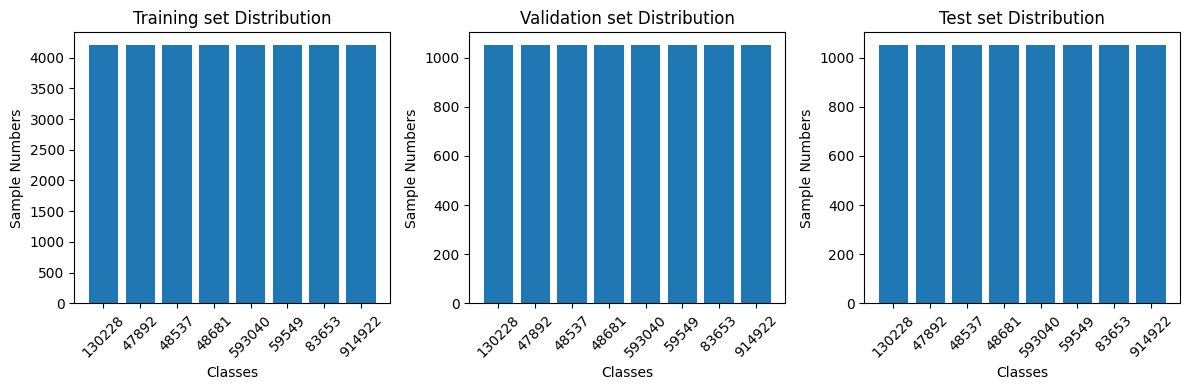

In [96]:
plt.figure(figsize=(12, 4))

# plot for train set
plt.subplot(1, 3, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title('Training set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

# plot for validation set
plt.subplot(1, 3, 2)
plt.bar(validation_class_counts.keys(), validation_class_counts.values())
plt.title('Validation set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

# plot for test set
plt.subplot(1, 3, 3)
plt.bar(test_class_counts.keys(), test_class_counts.values())
plt.title('Test set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Show some images for testing

In [97]:
# I create train_data above , and I will use it here
label_dict = {y: x for x, y in train_data.class_to_idx.items()}
label_dict

{0: '130228',
 1: '47892',
 2: '48537',
 3: '48681',
 4: '593040',
 5: '59549',
 6: '83653',
 7: '914922'}

# Labels and weights

In [98]:
class_weights = {
    47892: 0.3714,   # Impatiens glandulifera
    130228: 0.3025,  # Heracleum mantegazzianum
    914922: 0.1638,  # Reynoutria japonica
    59549: 0.0658,   # Lupinus polyphyllus
    48537: 0.0338,   # Lysichiton americanus
    83653: 0.0146,   # Rosa rugosa
    593040: 0.009,   # Reynoutria sachalinensis
    48681: 0.0034    # Spiraea
}

In [99]:
# Convert keys in label_dict to integers
label_dict_int = {int(key): value for key, value in label_dict.items()}
print(label_dict_int)

# Loop through each index in label_dict_int
for index, taxon_id in label_dict_int.items():
    # Retrieve the weight corresponding to the Taxon ID
    weight = class_weights.get(taxon_id)
    # If the weight exists, add it to the mapped dictionary
    if weight is not None:
        class_weights[taxon_id] = weight

print(class_weights)

{0: '130228', 1: '47892', 2: '48537', 3: '48681', 4: '593040', 5: '59549', 6: '83653', 7: '914922'}
{47892: 0.3714, 130228: 0.3025, 914922: 0.1638, 59549: 0.0658, 48537: 0.0338, 83653: 0.0146, 593040: 0.009, 48681: 0.0034}


# Show images

In [100]:
# Extract classes from label_dict
classes_to_display = [label_dict[y] for y in range(8)]  # Assuming you want to display the first 8 classes

# Define a function to display images for selected classes
def show_images(images, labels):
    plt.figure(figsize=(12, 8))
    count = 0
    for i in range(len(images)):
        label = labels[i].item()
        if label in classes_to_display:
            plt.subplot(4, 4, count + 1)
            image = to_pil_image(images[i])  # Convert tensor to PIL Image
            plt.imshow(image)
            plt.title(label_dict[label])  # Convert numerical label to string label
            plt.axis('off')
            count += 1
            if count >= len(classes_to_display):  # Break if all classes are displayed
                break
    plt.show()

# Get the first batch
for batch_idx, (images, labels) in enumerate(train_set):
    if batch_idx == 0:  # Only process the first batch
        show_images(images, labels)
        break

<Figure size 1200x800 with 0 Axes>

# Training the model

### Variables and settings

In [101]:
# if GPU is available , use it while training 
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cpu'

In [102]:
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)  # total number of images inside of loader
    num_batches = len(dataloader)    # number of batches

    model.train()  # sets the PyTorch model to training mode

    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # move X and y to GPU for faster training
        X, y = X.to(device), y.to(device)

        # make prediction 
        pred = model(X)
        # calculate loss 
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()   # compute parameters gradients
        optimizer.step()  # update parameters

        # Update training loss
        train_loss += loss.item()  # item() method extracts the loss’s value as a Python float

        # Calculate training accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # loss and accuracy
    train_loss = train_loss / num_batches
    accuracy = 100 * correct / size

    # use this accuracy list for plotting accuracy with matplotlib
    train_accuracies.append(accuracy)

    # Print training accuracy and loss at the end of epoch
    print(f"Training Accuracy: {accuracy:.2f}%, Training Loss: {train_loss:.4f}")

    return train_loss  # Return the training loss

In [103]:
def validation(dataloader, model, loss_fn, t):
    size = len(dataloader.dataset)  # total number of images inside of loader
    num_batches = len(dataloader)    # number of batches

    validation_loss, correct = 0, 0

    # sets the PyTorch model to evaluation mode, it will disable dropout layer
    model.eval()

    with torch.no_grad():  # disable gradient calculation
        for X, y in dataloader:
            # move X and y to GPU for faster training
            X, y = X.to(device), y.to(device)
            pred = model(X)  # make prediction
            validation_loss += loss_fn(pred, y).item()

            # if prediction is correct add 1 to correct variable.
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size

    validation_accuracies.append(accuracy)

    # Print test accuracy and loss at the end of epoch
    print(f"Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}")
    
    return validation_loss  # Return the validation loss

### 3 Moddel architecture

#### 3.1 Weighted Loss Function: 
Modify  loss function to incorporate class weights. <br>
This ensures that classes with lower representation in the dataset have a larger impact on the loss computation. <br>
<br>
Most deep learning frameworks provide a way to specify class weights when defining the loss function. <br>
For example, in PyTorch, you can use torch.nn.CrossEntropyLoss with the weight parameter.<br>

In [104]:
# Define class weights as a tensor
class_weights_tensor = torch.tensor([weight for weight in class_weights.values()], dtype=torch.float)

# Create a weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [105]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [106]:
# Define data loaders for training and validation sets
train_loader = DataLoader(dataset=train_data, batch_size=32, num_workers=1, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=32, num_workers=1, shuffle=False)

In [107]:
# Define optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)  # Adjust weight decay parameter as needed

In [108]:
# Initialize variables for early stopping
best_loss = float("inf")
patience = 3
counter = 0

In [109]:
num_epochs = 100

# Test optimized model CNN

In [110]:
# Lists to store the training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = F.cross_entropy(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        
        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = total_loss / len(train_data)
    train_accuracy = correct_train / len(train_data)
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    
    # Validation phase
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    
    with torch.no_grad():
        for val_images, val_labels in validation_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = F.cross_entropy(val_outputs, val_labels)
            total_val_loss += val_loss.item() * val_images.size(0)
            
            # Compute validation accuracy
            _, predicted_val = torch.max(val_outputs, 1)
            correct_val += (predicted_val == val_labels).sum().item()
    
    val_loss = total_val_loss / len(validation_data)
    val_accuracy = correct_val / len(validation_data)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

print("Training completed.")

Epoch 1/100, Training Loss: 1.4215, Training Accuracy: 0.6397
Validation Loss: 1.2338, Validation Accuracy: 0.6771
Epoch 2/100, Training Loss: 1.2513, Training Accuracy: 0.7013
Validation Loss: 1.3723, Validation Accuracy: 0.6863
Epoch 3/100, Training Loss: 1.1979, Training Accuracy: 0.7216
Validation Loss: 1.6198, Validation Accuracy: 0.6938
Epoch 4/100, Training Loss: 1.1895, Training Accuracy: 0.7368
Validation Loss: 1.3387, Validation Accuracy: 0.7050
Early stopping triggered.
Training completed.


Train the Model: Train your Bayesian CNN model using the training data. During training, the model learns the parameters while incorporating Bayesian priors.
Approximate Posterior Distribution: After training, use Bayesian inference techniques such as variational inference or MCMC sampling to approximate the posterior distribution over the model parameters. This involves sampling from the posterior distribution to obtain multiple sets of parameters.
Perform Prediction Sampling: For each set of sampled parameters, perform prediction sampling by forwarding the input images through the model. This yields a set of predictions for each input image, reflecting the uncertainty due to parameter uncertainty.
Aggregate Predictions: Aggregate the predictions obtained from multiple parameter samples to compute the posterior probabilities for each class label. This can be done by averaging the predicted probabilities across all samples for each class.
Visualize Posterior Probabilities: Finally, visualize the posterior probabilities for each class label using suitable visualization techniques such as histograms, probability density plots, or heatmaps. This visualization provides insights into the model's confidence in each class assignment for a given input image.

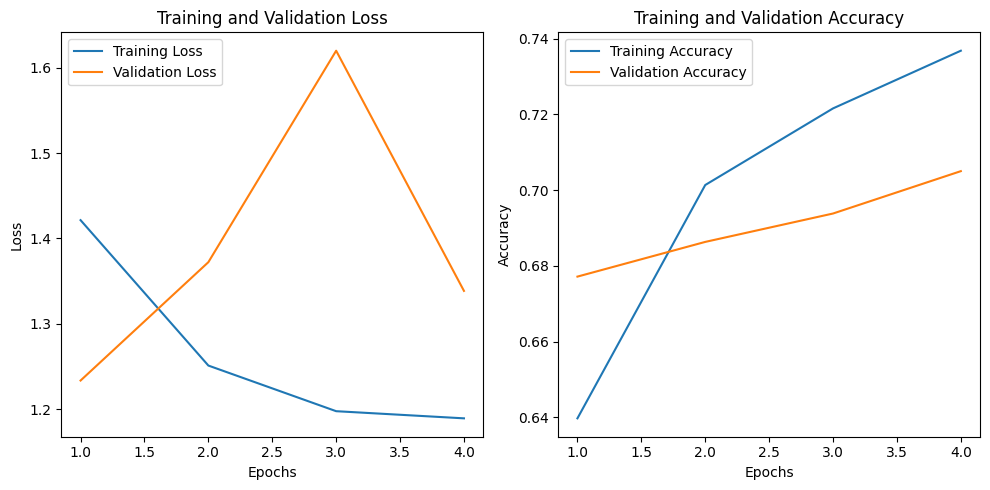

In [111]:
# Plotting the training and validation metrics
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [112]:
# Save the model after training
torch.save(model, './models/trained_model3b.pth')
print("Model 3b saved!")

Model 3b saved!


# Analysis

Posterior Approximation with Variational Inference:
Define a Variational Distribution: Choose a family of distributions (e.g., Gaussian) to approximate the true posterior distribution.
Optimization: Optimize the parameters of the variational distribution to minimize the Kullback-Leibler divergence between the variational distribution and the true posterior.
Sample from the Variational Distribution: Once the variational distribution is optimized, you can sample from it to obtain sets of parameters that approximate the posterior distribution.


Posterior Approximation with MCMC Sampling:
Define Markov Chain Monte Carlo (MCMC) Sampler: Choose an MCMC sampler such as Metropolis-Hastings or Gibbs sampling.
Burn-in Period: Run the sampler for a sufficient number of iterations to allow it to reach its stationary distribution (burn-in period).
Sample from the Posterior: After the burn-in period, collect samples from the Markov chain, ensuring that the samples are approximately from the posterior distribution.


Posterior Analysis:
Diagnostic Checks: Perform diagnostic checks to ensure convergence and assess the mixing properties of the MCMC sampler.
Summary Statistics: Compute summary statistics (e.g., mean, median, credible intervals) from the posterior samples to characterize the uncertainty in the model parameters.
Use Posterior Samples for Prediction: Once you have obtained posterior samples of the model parameters, you can perform prediction sampling by forwarding input data through the model with each set of sampled parameters to obtain predictions that account for parameter uncertainty.

In [113]:
'''
Approximate Posterior Distribution: After training, you would 
typically use Bayesian inference techniques like variational inference 
or MCMC sampling to approximate the posterior distribution 
over the model parameters. It seems you've achieved this step 
implicitly during training by incorporating Bayesian priors.
'''

"\nApproximate Posterior Distribution: After training, you would \ntypically use Bayesian inference techniques like variational inference \nor MCMC sampling to approximate the posterior distribution \nover the model parameters. It seems you've achieved this step \nimplicitly during training by incorporating Bayesian priors.\n"

### Perform Prediction Sampling


Perform Predicton Sampling: Once you've approximated the posterior distribution, you would perform 
prediction sampling by forwarding input images through the model with multiple sets of parameters 
sampled from the posterior distribution. This step involves accounting for parameter uncertainty, 
which is a key aspect of Bayesian inference.


In [114]:
# Load the saved state dictionary
checkpoint = torch.load('./models/trained_model3.pth')

# Adjust the size of the fully connected layer weights
# Assuming you want to resize it to have 8 output units
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 8)  # Adjust the number of output units as needed

# Load state dictionary into model
model.load_state_dict(checkpoint, strict=False)  # Set strict to False to ignore missing keys

# Ensure the model is in evaluation mode
model.eval()

SimpleCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [135]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define data loader for validation set
validation_loader = DataLoader(dataset=validation_data, batch_size=1, num_workers=1, shuffle=False)

# Define data loader for test set
test_loader = DataLoader(dataset=test_data, batch_size=1, num_workers=1, shuffle=False)

# Perform prediction sampling and aggregate predictions
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        predictions = []
        for _ in range(10):  # usually 10-100
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions.append(probabilities)
        all_predictions.append(np.mean(predictions, axis=0))

# 113min

### Visualize Posterior Probabilities

In [136]:
num_classes = len(label_dict)
print(num_classes)

# Map class indices to labels
class_labels = [label_dict[i] for i in range(num_classes)]
print(class_labels)

8
['130228', '47892', '48537', '48681', '593040', '59549', '83653', '914922']


In [137]:
# Visualize posterior probabilities for the first image
posterior_probabilities = all_predictions[0] 
print(posterior_probabilities)

[[0.36660865 0.05299456 0.14220335 0.14336297 0.02735058 0.17469014
  0.08847488 0.00431485]]


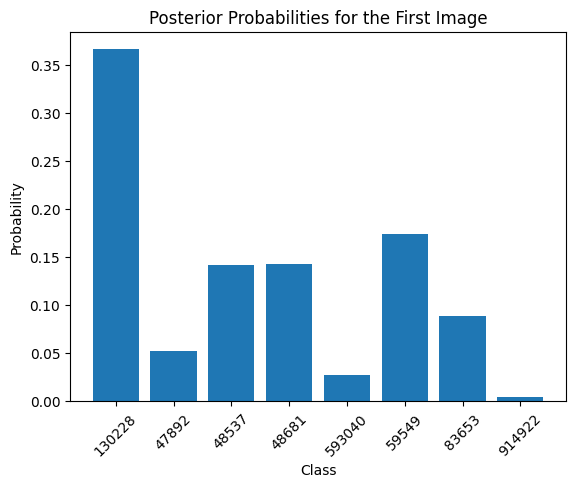

In [138]:
# Convert posterior probabilities to a numpy array
posterior_probabilities = np.array(posterior_probabilities[0])

# Create a bar plot
plt.figure()
plt.bar(np.arange(len(class_labels)), posterior_probabilities)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Posterior Probabilities for the First Image')
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
plt.show()

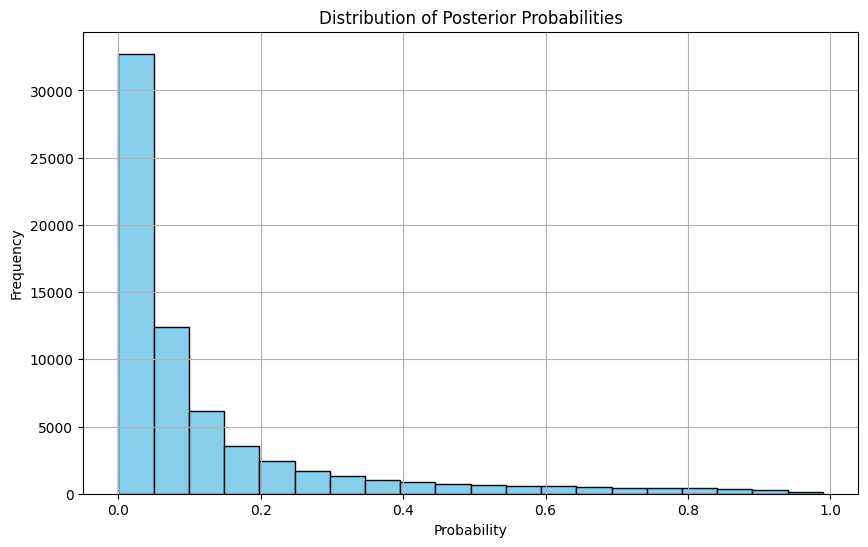

In [139]:
# Concatenate all posterior probabilities from all images
all_posterior_probabilities = np.concatenate(all_predictions, axis=0)

# Flatten the array to get a 1D array of probabilities
flat_posterior_probabilities = all_posterior_probabilities.flatten()

# Plot the histogram of posterior probabilities
plt.figure(figsize=(10, 6))
plt.hist(flat_posterior_probabilities, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Posterior Probabilities')
plt.grid(True)
plt.show()

most of my classes are expected to have low probabilities while one class should have high probabilities, then the histogram's distribution reflects expectation. You'd anticipate a bimodal distribution, with one peak representing low probabilities for most classes and another peak representing high probabilities for the specific class. This distribution pattern aligns with my model's behavior, indicating low uncertainty for one class and higher uncertainty for the others.

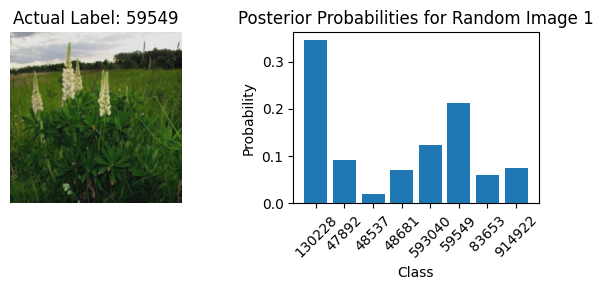

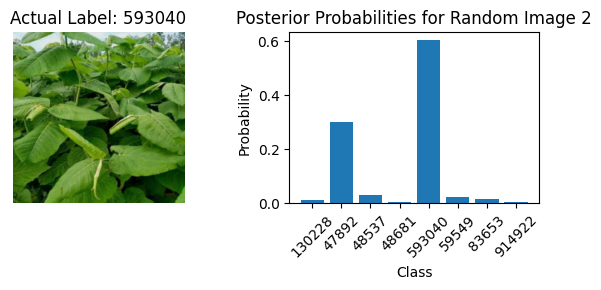

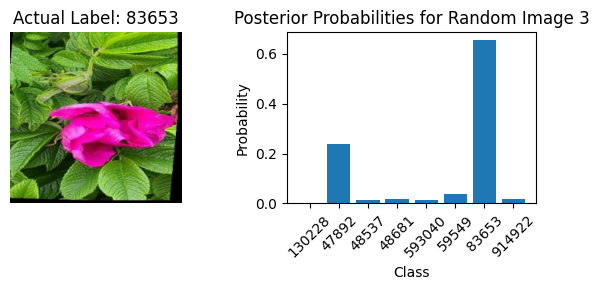

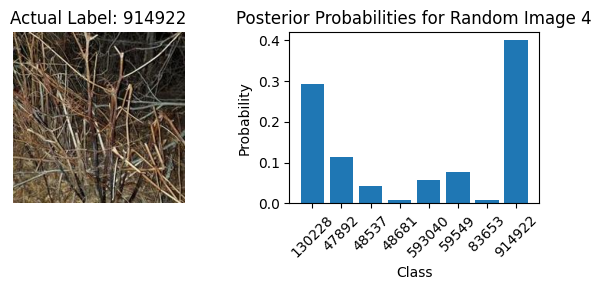

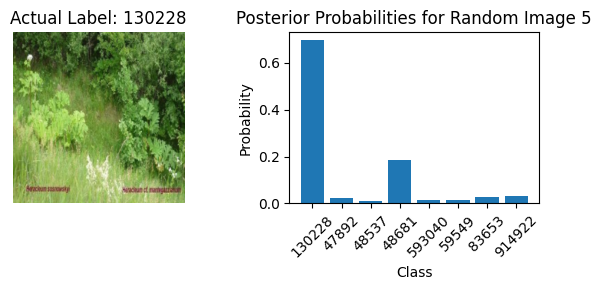

In [140]:
def visualize_random_images(all_predictions, label_dict, dataset, num_images=5):
    # Get the total number of images in the dataset
    total_images = len(dataset)

    # Generate random indices to select random images
    random_indices = random.sample(range(total_images), num_images)

    # Iterate over the randomly selected images
    for i, index in enumerate(random_indices):
        # Extract posterior probabilities for the current image
        posterior_probabilities = all_predictions[index]

        # Extracting class labels from the label dictionary
        class_labels = list(label_dict.values())

        # Convert posterior probabilities to a numpy array
        posterior_probabilities = np.array(posterior_probabilities[0])

        # Retrieve the actual image and its label from the dataset
        image, label_index = dataset[index]
        actual_label = label_dict[label_index]

        # Plot the image
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))  # Assuming image is a PyTorch tensor
        plt.axis('off')
        plt.title(f'Actual Label: {actual_label}')

        # Create a bar plot for posterior probabilities
        plt.subplot(1, 2, 2)
        plt.bar(np.arange(len(class_labels)), posterior_probabilities)
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.title(f'Posterior Probabilities for Random Image {i+1}')
        plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage: visualize posterior probabilities for 5 random images
visualize_random_images(all_predictions, label_dict, test_data, num_images=5)

In [141]:
prediction_probabilities = all_predictions  

# Extract true labels from your test dataset
true_labels = np.array([label for _, label in test_data])

In [142]:
prediction_probabilities = np.vstack(prediction_probabilities)

In [143]:
# Calculate prediction errors (cross-entropy loss)
# Use true labels to index prediction probabilities
prediction_errors = -np.log(prediction_probabilities[np.arange(len(true_labels)), true_labels])

In [144]:
# Calculate uncertainty measures (e.g., entropy)
entropy = -np.sum(prediction_probabilities * np.log(prediction_probabilities), axis=1)

# Calculate correlation between uncertainty and prediction errors
correlation = np.corrcoef(entropy, prediction_errors)[0, 1]

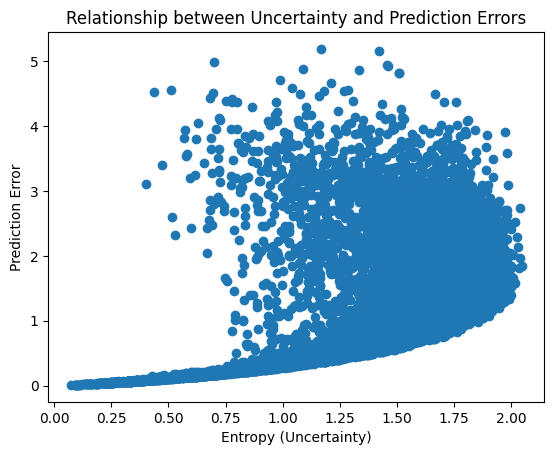

Correlation between uncertainty and prediction errors: 0.48762907059491384


In [145]:
# Visualize the relationship
plt.scatter(entropy, prediction_errors)
plt.xlabel('Entropy (Uncertainty)')
plt.ylabel('Prediction Error')
plt.title('Relationship between Uncertainty and Prediction Errors')
plt.show()

print("Correlation between uncertainty and prediction errors:", correlation)

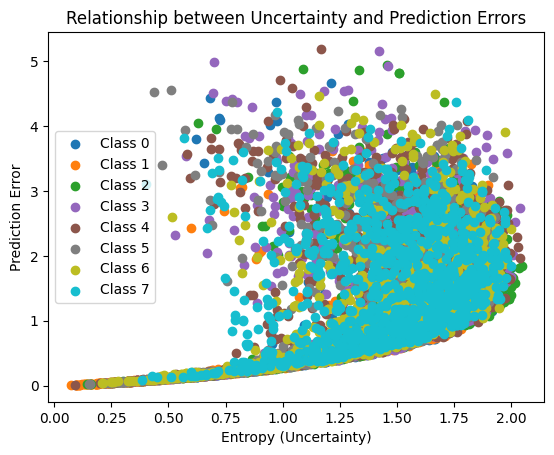

Correlation between uncertainty and prediction errors: 0.48762907059491384


In [146]:
# Get unique class labels
unique_labels = np.unique(true_labels)

# Create a colormap with a unique color for each class
num_classes = len(unique_labels)
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

# Plot each class separately with a unique color
for label, color in zip(unique_labels, colors):
    indices = np.where(true_labels == label)
    plt.scatter(entropy[indices], prediction_errors[indices], label=f'Class {label}', color=color)

plt.xlabel('Entropy (Uncertainty)')
plt.ylabel('Prediction Error')
plt.title('Relationship between Uncertainty and Prediction Errors')
plt.legend()
plt.show()

print("Correlation between uncertainty and prediction errors:", correlation)

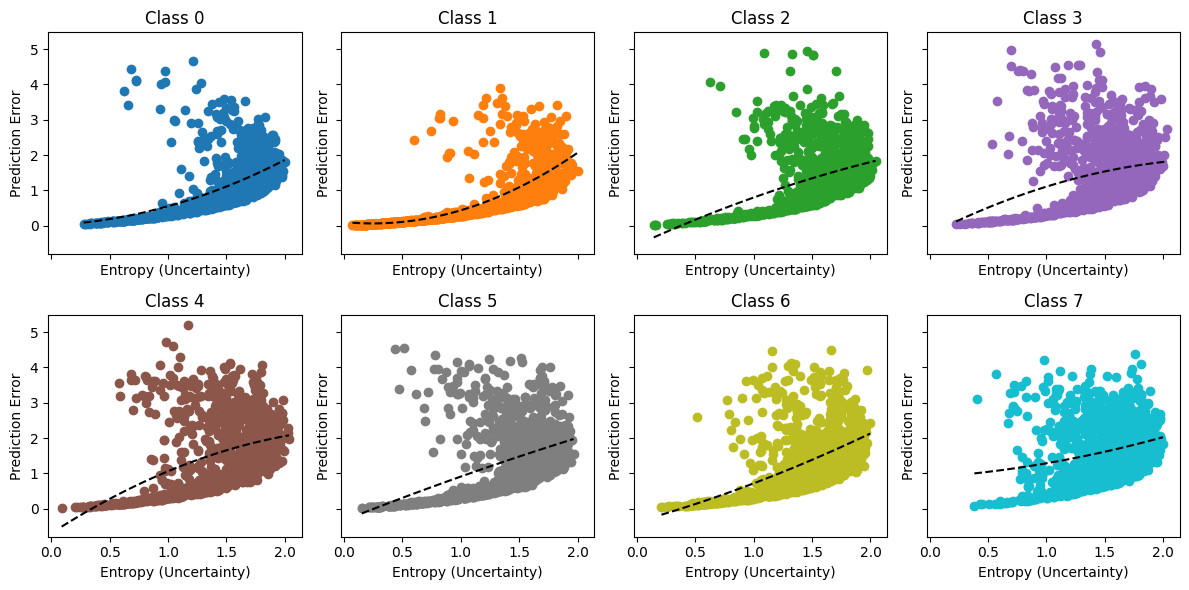

In [147]:
# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)

# Plot each class separately with a unique color
for i, (label, color) in enumerate(zip(unique_labels, colors)):
    row = i // 4
    col = i % 4
    indices = np.where(true_labels == label)
    axes[row, col].scatter(entropy[indices], prediction_errors[indices], label=f'Class {label}', color=color)
    axes[row, col].set_title(f'Class {label}')
    axes[row, col].set_xlabel('Entropy (Uncertainty)')
    axes[row, col].set_ylabel('Prediction Error')
    
    # Fit polynomial regression
    degree = 2
    poly_features = np.column_stack([entropy[indices], entropy[indices]**2])  # Create polynomial features
    lr = LinearRegression()
    lr.fit(poly_features, prediction_errors[indices])
    line_x = np.linspace(np.min(entropy[indices]), np.max(entropy[indices]), 100)
    line_y = lr.predict(np.column_stack([line_x, line_x**2]))  # Predict using polynomial features
    
    # Plot polynomial regression line
    axes[row, col].plot(line_x, line_y, color='black', linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()